# Designing an Stability Augmentation System

### Criação da aeronave

In [1]:
import numpy as np
from numpy import radians
import matplotlib.pyplot as plt

In [2]:
# Creates vehicle and set values
from pyaat.aircraft import Aircraft
minhaAeronave = Aircraft(mass=45e3, Ixx=0.554e6, Iyy=2.53e6,
                         Izz =3.01e6, Izx=0.106e6, Cbarw =3.666,
                         bw=28.42, Sw=95.0)


# Aerodynamic coeficients
minhaAeronave.coef0 = [0.0252, 0.0, 0.382, 0.0, 0.0622, 0.0]
minhaAeronave.coefALPHA = [0.2010, 0.0, 6.29, 0.0, -3.63, 0.0]
minhaAeronave.coefBETA = [0.0, 0.785, 0.0, -0.121, 0.0, 0.174]
minhaAeronave.coefP = [0.0, -0.0794, 0.0, -0.522, 0.0, -0.0587]
minhaAeronave.coefQ = [0.281, 0.0, 14.6, 0.0, -45.5, 0.0]
minhaAeronave.coefR = [0.0, 0.572, 0.0, 0.254, 0.0, -0.277]

minhaAeronave.CLmax = 2.4
minhaAeronave.qmax = 23052.05 # considering 700km/h at sea level
minhaAeronave.Vinf = 200

# Environment

minhaAeronave.set_control_surface('Profundor', [0.0126, 0.0, 0.3891, 0.0, -1.5980, 0.0],(radians(-30), radians(30)))
minhaAeronave.set_control_surface('Aileron', [0.0, 0.0094, 0.0, -0.1784, 0.0, 0.0080],(radians(-20), radians(30)))
minhaAeronave.set_control_surface('Leme', [0.0, -0.3030, 0.0, -0.0464, 0.0, -0.1594],(radians(-40), radians(40)))

### Criação da atmosfera

In [3]:
from pyaat.atmosphere import atmosISA
minhaAtmosfera = atmosISA()

### Criação da gravidade

In [4]:
from pyaat.gravity import Earth_NewtonGravity
minhaGravidade = Earth_NewtonGravity()

### Criação do modelo propulsivo

In [5]:
from pyaat.propulsion import JetModel
MotorEsquerdo = JetModel('Motor esquerdo', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorEsquerdo.set_position(np.array([0, -5, 1.42]))
MotorEsquerdo.set_attitude(np.array([0., radians(0.), 0.]))

MotorDireito = JetModel('Motor direito', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorDireito.set_position(np.array([0, 5.0, 1.42]))
MotorDireito.set_attitude(np.array([0., radians(0.), 0.]))

minhaPropulsao = [MotorEsquerdo, MotorDireito]

### Criação do sistema

In [6]:
from pyaat.system import system
meuSistema = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade)

### Cálculo do balanço

In [7]:
varFixas = {'zo':-10000.0, 'u': 224.6, 'phi':0.0, 'Motor esquerdo phip':0.0, 'Motor direito phip': 0.0,  'Motor esquerdo thetap':np.radians(3.0), 'Motor direito thetap': np.radians(3.0), 'v': 0.0,}

varDesejadas = {'zod':0.0, 'ud':0.0, 'vd':0.0, 'wd':0.0, 'phid':0.0, 'psid': 0.0, 'thetad':0.0, 'pd':0.0 , 'qd':0.0, 'rd':0.0}

varLivres = {'w':1.0, 'theta':1.0, 'p': 1.0, 'q':1.0, 'r':1.0, 'Motor direito thrust': 0.5, 'Motor esquerdo thrust': 0.5, 'Aileron': np.radians(1.0), 'Profundor':0.0, 'Leme': np.radians(0.5)}

Xe, Ue = meuSistema.trimmer(condition = 'general', fixed = varFixas, desired = varDesejadas, free = varLivres)

### Simulação perturbada

In [8]:
from pyaat.wind import windFAR25
rajada = windFAR25(MaxSpeed = 5, x_start= 500, x_end= 1000, y_start = -1000, y_end = 1000)
meusVentos = []

In [9]:
from pyaat.pyaatcontrol import doublet

Perturbacao_controle = doublet('Profundor', amplitude = np.radians(3.), t_init =  40, T = 4)
openloopcontrols = [Perturbacao_controle]

### Inclui Sensores e atuadores

In [10]:
from pyaat.pyaatcontrol import actuator
act2 = actuator(name = 'ss profundor', command = 'Profundor', tau = 0.2)

from pyaat.pyaatcontrol import sensor
sens3 = sensor(name = 'wf', state = 'w', tau = 1/10)

actuatorsAndFilters = [act2, sens3]

In [11]:
meuSistema = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade,
                    wind = meusVentos,
                    extraDynamics = actuatorsAndFilters)

In [12]:
print(meuSistema.controlsNames)

['Profundor', 'Aileron', 'Leme', 'Motor esquerdo thrust', 'Motor esquerdo psip', 'Motor esquerdo thetap', 'Motor direito thrust', 'Motor direito psip', 'Motor direito thetap']


In [13]:
A, B = meuSistema.Linearize(Xe, Ue)

In [14]:
Am = A
Bm = B[:,:]
Cm = np.zeros((2, len(Am)))
Dm = np.zeros((len(Cm), np.shape(Bm)[1]))

import control as control
sys = control.ss(Am, Bm, Cm, Dm)

In [15]:
solution1, controls1 = meuSistema.simulate(Xe, Ue, T0 = 0.0, TF = 60, dt = 0.01,
                                           perturbation=True,
                                           control = openloopcontrols)
tempo1  = meuSistema.time

### Inclui controladores

In [16]:
from pyaat.pyaatcontrol import P, loop, LowPassFilter

P1 = P(name = 'P1', gain = 0.001)
loop1 = loop(name = 'L1', Xmeasure = 'wf', Xreference = 'w', command = 'Profundor')
loop1.loopControls = [P1]
P2 = P(name = 'P2', gain = 1.4)
loop2 = loop(name = 'L2', Xmeasure= 'q', Xreference = 'q',  command ='Profundor')
loop2.loopControls = [P2]
closedloopcontrols = [loop1, loop2]

In [17]:
meuSistema2 = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade,
                    wind = meusVentos,
                    extraDynamics = actuatorsAndFilters,
                    control = closedloopcontrols)

In [18]:
solution2, controls2 = meuSistema2.simulate(Xe, Ue, TF = 60, control = openloopcontrols)
tempo2  = meuSistema2.time

In [19]:
from numpy import sqrt
def fingOmegaZeta(real, img):
    omega = np.sqrt((-real)**2 + img**2)
    zeta = -real/(np.sqrt((-real)**2+img**2))
    
    if (img==0):
        omega = 1/real
        zeta = "Non-oscilatory"
        
    return omega, zeta

In [20]:
Xea = np.append(Xe,[Ue[0], Xe[5]])
Aa, Ba = meuSistema2.FullLinearize(Xea, Ue)

In [21]:
Xea = np.append(Xe,[Ue[0], Xe[5]])
Aa, Ba = meuSistema2.FullLinearize(Xea, Ue)

Am = Aa
Bm = Ba[:,:]
Cm = np.zeros((2, len(Am)))
Dm = np.zeros((len(Cm), np.shape(Bm)[1]))

import control as control
sys = control.ss(Am, Bm, Cm, Dm)

Aprint = np.around(Am, decimals = 4)
Bprint = np.around(Bm, decimals = 4)

In [22]:
from pyaat.flightmechanics import longMatrix, shortPeriodMatrix, phugoidMatrix
from numpy.linalg import eig
Al, Bl = longMatrix(Aa, Ba)
Asp, Bsp = shortPeriodMatrix(Aa, Ba)
Aph, Bph = phugoidMatrix(Aa, Ba)
wt, vt = eig(Aa)
wt

array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , -9.96333813e+00+0.j        ,
       -2.49133929e+00+3.92137586j, -2.49133929e+00-3.92137586j,
       -1.87571863e+00+0.j        , -3.80903462e+00+0.j        ,
       -1.21847607e-01+1.33389932j, -1.21847607e-01-1.33389932j,
       -2.04146162e-03+0.05856661j, -2.04146162e-03-0.05856661j,
       -1.03085529e-03+0.j        ,  5.13461462e-03+0.j        ])

In [23]:
from pyaat.flightmechanics import phugoidQuality, shortPeriodQuality

In [24]:
w, z = fingOmegaZeta(-1.88331925e-03, 0.06223688)

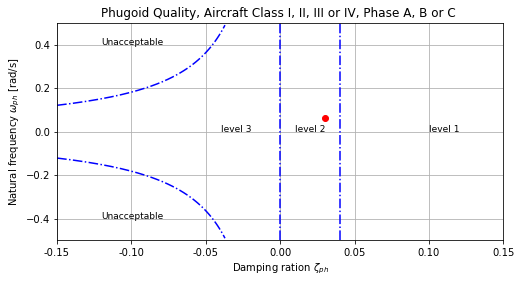

In [25]:
phugoidQuality(w, z, aircraft = 'III', phase = 'B')
#plt.savefig('phugoid_CL.pdf', dpi = 400, bbox_inches='tight')

In [26]:
w, z = fingOmegaZeta(-1.72445545, 2.74443156)

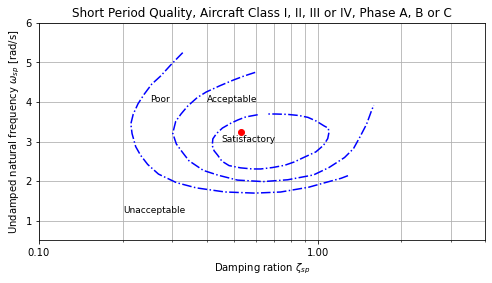

In [27]:
shortPeriodQuality(w, z, aircraft = 'III', phase = 'B')
#plt.savefig('shortPeriod_CL.pdf', dpi = 400, bbox_inches='tight')

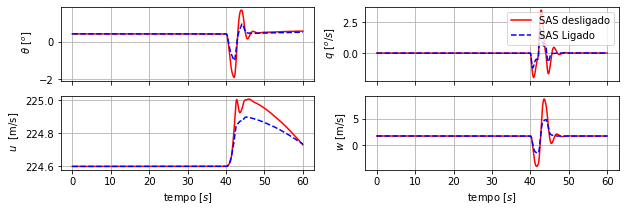

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,3))
ax[0,0].plot(tempo1, np.around(np.degrees(solution1[:,7]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0,0].plot(tempo2, np.around(np.degrees(solution2[:,7]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0,0].set_ylabel(r' $\theta~ [^o]$')
ax[0,0].grid()

ax[1,0].plot(tempo1, np.around((solution1[:,3]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1,0].plot(tempo2, np.around((solution2[:,3]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1,0].set_ylabel(r' $u$  [m/s]')
ax[1,0].grid()
ax[1,0].set_xlabel(r'tempo $[s]$')

ax[1,1].plot(tempo1, np.around((solution1[:,5]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1,1].plot(tempo2, np.around((solution2[:,5]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1,1].set_ylabel(r' $w$ [m/s]')
ax[1,1].set_xlabel(r'tempo $[s]$')
ax[1,1].grid()

ax[0, 1].plot(tempo1, np.around(np.degrees(solution1[:,10]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0, 1].plot(tempo2, np.around(np.degrees(solution2[:,10]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0, 1].set_ylabel(r' $q~ [^o/s]$')
ax[0, 1].legend(loc = 'upper right')
ax[0, 1].grid()

In [29]:
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# ax[0].plot(tempo2, np.around(meuSistema2.windval[:,0], decimals=4), label = r'SAS Ligado', color = 'k', linestyle = '-')
# ax[0].set_ylabel(r'vento em x')
# ax[0].grid()

# ax[1].plot(tempo2, np.around(meuSistema2.windval[:,1], decimals=4), label = r'SAS Ligado', color = 'k', linestyle = '-')
# ax[1].set_ylabel(r'vento em y')
# ax[1].grid()

# ax[2].plot(tempo2, np.around(meuSistema2.windval[:,2], decimals=4), label = r'SAS Ligado', color = 'k', linestyle = '-')
# ax[2].set_ylabel(r'vento em z')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# #plt.savefig('vento.pdf', dpi = 400, bbox_inches='tight')


# plt.figure(figsize=(8,2))
# plt.plot(solution1[:,0], np.around(meuSistema2.windval[:,2], decimals=4), label = r'SAS Ligado', color = 'k', linestyle = '-')
# plt.ylabel(r'Vento em $z_o$ [m/s]')
# plt.xlabel(r'Posição $x_o$ [m]')
# plt.grid()
# plt.savefig('vento.pdf', dpi = 400, bbox_inches='tight')

### Plot ângulos

In [30]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# ax[0].plot(tempo1, np.around(np.degrees(solution1[:,6]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around(np.degrees(solution2[:,6]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$\phi~ [^o]$')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(tempo1, np.around(np.degrees(solution1[:,7]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around(np.degrees(solution2[:,7]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r' $\theta~ [^o]$')
# ax[1].grid()

# ax[2].plot(tempo1, np.around(np.degrees(solution1[:,8]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[2].plot(tempo2, np.around(np.degrees(solution2[:,8]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[2].set_ylabel(r' $\psi~ [^o]$')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# # #plt.savefig('angulo_cruize.pdf', dpi = 400, bbox_inches='tight')

Text(0.5, 0, 'tempo $[s]$')

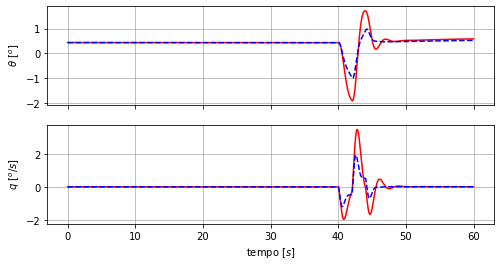

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,4))
ax[0].plot(tempo1, np.around(np.degrees(solution1[:,7]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0].plot(tempo2, np.around(np.degrees(solution2[:,7]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0].set_ylabel(r' $\theta~ [^o]$')
ax[0].grid()

ax[1].plot(tempo1, np.around(np.degrees(solution1[:,10]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1].plot(tempo2, np.around(np.degrees(solution2[:,10]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1].set_ylabel(r' $q~ [^o/s]$')
ax[1].grid()
ax[1].set_xlabel(r'tempo $[s]$')
#plt.savefig('Variaveis_angulares.png', dpi = 400, bbox_inches='tight')

### Velocidade ângular

In [32]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# ax[0].plot(tempo1, np.around(np.degrees(solution1[:,9]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around(np.degrees(solution2[:,9]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$p~ [^o/s]$')
# ax[0].legend(loc = 'upper right')
# ax[0].grid()

# ax[1].plot(tempo1, np.around(np.degrees(solution1[:,10]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around(np.degrees(solution2[:,10]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r' $q~ [^o/s]$')
# ax[1].grid()

# ax[2].plot(tempo1, np.around(np.degrees(solution1[:,11]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[2].plot(tempo2, np.around(np.degrees(solution2[:,11]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[2].set_ylabel(r' $r~ [^o/s]$')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# #plt.savefig('angulo_speed_cruize.pdf', dpi = 400, bbox_inches='tight')

### Velocidades lineares

In [33]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# ax[0].plot(tempo1, np.around((solution1[:,3]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around((solution2[:,3]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$u$ [m/s]')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(tempo1, np.around((solution1[:,4]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around((solution2[:,4]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r' $v$ [m/s]')
# ax[1].grid()

# ax[2].plot(tempo1, np.around((solution1[:,5]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[2].plot(tempo2, np.around((solution2[:,5]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[2].set_ylabel(r' $w$ [m/s]')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# #plt.savefig('velocidade_cruize.pdf', dpi = 400, bbox_inches='tight')

In [34]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8,4))
# ax[0].plot(tempo1, np.around((solution1[:,3]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(tempo2, np.around((solution2[:,3]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$u$ [m/s]')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(tempo1, np.around((solution1[:,5]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(tempo2, np.around((solution2[:,5]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r' $w$ [m/s]')
# ax[1].set_xlabel(r'tempo $[s]$')
# ax[1].grid()
# #plt.savefig('velocidades_com_SAS.pdf', dpi = 400, bbox_inches='tight')

### Posição

In [35]:
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,4))
# ax[0].plot(np.around(solution1[:,0], decimals=4), np.around(solution1[:,1], decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[0].plot(np.around(solution2[:,0], decimals=4), np.around(solution2[:,1], decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[0].set_ylabel(r'$y_o$ [m]')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(np.around(solution1[:,0], decimals=4), np.around(-solution1[:,2], decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# ax[1].plot(np.around(solution2[:,0], decimals=4), np.around(-solution2[:,2], decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# ax[1].set_ylabel(r'Altitude [m]')
# ax[1].set_xlabel(r'$x_o$ [m]')
# ax[1].grid()
# #plt.savefig('Posicao_SAS.pdf', dpi = 400, bbox_inches='tight')

### Controles

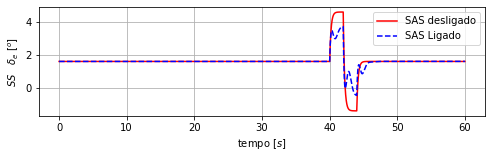

In [36]:
# # fig, ax = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(10,8))
# # ax[0].plot(tempo1, np.around(np.degrees(controls1[0,:]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# # ax[0].plot(tempo2, np.around(np.degrees(controls2[0,:]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# # ax[0].set_ylabel(r'$\delta_e$ $[^o]$')
# # ax[0].grid()

# # ax[1].plot(tempo1, np.around(np.degrees(controls1[1,:]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# # ax[1].plot(tempo2, np.around(np.degrees(controls2[1,:]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# # ax[1].set_ylabel(r'$\delta_a$ $[^o]$')
# # ax[1].grid()

# # ax[2].plot(tempo1, np.around(np.degrees(controls1[2,:]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# # ax[2].plot(tempo2, np.around(np.degrees(controls2[2,:]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# # ax[2].set_ylabel(r'$\delta_r$ $[^o]$')
# # ax[2].grid()

# # ax[3].plot(tempo1, np.around((controls1[3,:])*100, decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# # ax[3].plot(tempo2, np.around((controls2[3,:])*100, decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# # ax[0].legend(loc = 'upper right')
# # ax[3].set_ylabel(r'$\delta_{pe}$ $[\%]$')
# # ax[3].grid()

# # ax[4].plot(tempo1, np.around((controls1[6,:])*100, decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
# # ax[4].plot(tempo2, np.around((controls2[6,:])*100, decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
# # ax[4].set_ylabel(r'$\delta_{pd}$ $[\%]$')
# # ax[4].set_xlabel(r'tempo $[s]$')
# # ax[4].grid()
# # #plt.savefig('controles_cruise.pdf', dpi = 400, bbox_inches='tight')


plt.figure(figsize=(8,2))
plt.plot(tempo1, np.around(np.degrees(solution1[:,12]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
plt.plot(tempo2, np.around(np.degrees(solution2[:,12]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
plt.ylabel(r'$SS \ ~ \ \delta_e$ $[^o]$')
plt.xlabel(r'tempo $[s]$')
plt.legend(loc = 'upper right')
plt.grid()
#plt.savefig('Profundor_SAS.png', dpi = 400, bbox_inches='tight')


In [37]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,6))
# #ax[0].plot(tempo2, np.around(solution2[:,14], decimals=4), label = r'w com filtro', color = 'b', linestyle = '--')
# ax[0].plot(tempo2, np.around((solution2[:,13]), decimals=4), label = r'w do barramento', color = 'b', linestyle = '--')
# ax[0].plot(tempo2, np.around((solution2[:,5]), decimals=4), label = r'w real', color = 'r', linestyle = '-')
# ax[0].set_ylabel(r'$P1$')
# ax[0].legend('upper left')
# ax[0].legend(loc = 'upper right')
# ax[0].grid()

# #ax[1].plot(tempo2, np.around(np.degrees(solution2[:,15]), decimals=4), color = 'b', linestyle = '--')
# ax[1].set_ylabel(r' $P2$')
# ax[1].grid()

# #ax[2].plot(tempo2, np.around(np.degrees(solution2[:,16]), decimals=4), color = 'b', linestyle = '--')
# ax[2].set_ylabel(r' $P3$')
# ax[2].set_xlabel(r'tempo $[s]$')
# ax[2].grid()
# #plt.savefig('angulo_speed_cruize.pdf', dpi = 400, bbox_inches='tight')